In [1]:
# Importing the required modules

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision  # This library is used for computer vision tasks
import torchvision.transforms as transforms
import torchvision.datasets as ImageFolder
import os
import torch.nn.parallel
import json
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import random

print(torch.__version__)
print(torchvision.__version__)

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(False) # Needed for reproducible results


latent_vector = 200
ngf = 128
ndf = 128
nc = 1
num_of_epochs = 50
learning_rate = 0.0001
beta1 = 0.5
ngpu = 1

2.6.0+cu126
0.21.0+cu126
Random Seed:  2031


In [2]:
# Creating a class for loading datasets i.e., Truss System Geometries

class TrussGeometriesData(Dataset):
    def __init__(self, images_dir, labels_file, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        
        # Load labels from json file
        with open(labels_file, 'r') as f:
            self.labels = json.load(f)
            
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Get the label dictionary for the sample
        label_entry = self.labels[idx]
        
        # Extract the sample number and construct the image filename
        sample_number = label_entry['sample_number']
        image_filename = f"binary_image_{sample_number}.png" 
        image_path = os.path.join(self.images_dir, image_filename)
        
        # Load image and apply any transformations
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        
        # Convert label data to tensors
        frequencies = torch.tensor(label_entry['frequencies'], dtype=torch.float32)
        displacements_x = torch.tensor(label_entry['displacements_x'], dtype=torch.float32)
        
        # You can return the labels as a dictionary or a tuple
        label = {'frequencies': frequencies, 'displacements_x': displacements_x}
        return image, label
        
        
# Define any image transformations (e.g., resizing, tensor conversion)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


In [3]:
# Specify the directory containing images and the path to the labels JSON file
images_dir = r'D:\TUM files\Master Thesis\Thesis Data\Deep Learning Models\image_samples_2500'
labels_file = r'D:\TUM files\Master Thesis\Thesis Data\Deep Learning Models\all_results.json'

In [4]:
dataset = TrussGeometriesData(images_dir, labels_file, transform=transform)

# Warp the dataset in dataloader for batching and shuffling
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Switching the device to GPU for faster computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
len(dataset)

2488

In [6]:
dataset[2400]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2510,  ..., 0.3608, 0.0157, 0.0000],
          ...,
          [0.0000, 0.0000, 0.3608,  ..., 0.5176, 0.0235, 0.0000],
          [0.0000, 0.0000, 0.0157,  ..., 0.0235, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]),
 {'frequencies': tensor([ 109.,  118.,  127.,  136.,  145.,  154.,  163.,  172.,  181.,  190.,
           199.,  208.,  217.,  226.,  235.,  244.,  253.,  262.,  271.,  280.,
           289.,  298.,  307.,  316.,  325.,  334.,  343.,  352.,  361.,  370.,
           379.,  388.,  397.,  406.,  415.,  424.,  433.,  442.,  451.,  460.,
           469.,  478.,  487.,  496.,  505.,  514.,  523.,  532.,  541.,  550.,
           559.,  568.,  577.,  586.,  595.,  604.,  613.,  622.,  631.,  640.,
           649.,  658.,  667.,  676.,  685.,  694.,  703.,  712.,  721.,  730.,
           

In [7]:
image = dataset[400]
print(image)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2510,  ..., 0.3608, 0.0157, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3608,  ..., 0.5176, 0.0235, 0.0000],
         [0.0000, 0.0000, 0.0157,  ..., 0.0235, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), {'frequencies': tensor([ 109.,  118.,  127.,  136.,  145.,  154.,  163.,  172.,  181.,  190.,
         199.,  208.,  217.,  226.,  235.,  244.,  253.,  262.,  271.,  280.,
         289.,  298.,  307.,  316.,  325.,  334.,  343.,  352.,  361.,  370.,
         379.,  388.,  397.,  406.,  415.,  424.,  433.,  442.,  451.,  460.,
         469.,  478.,  487.,  496.,  505.,  514.,  523.,  532.,  541.,  550.,
         559.,  568.,  577.,  586.,  595.,  604.,  613.,  622.,  631.,  640.,
         649.,  658.,  667.,  676.,  685.,  694.,  703.,  712.,  721.,  730.,
         739.,  748.,  757.,  

In [8]:
# Iterate over the dataloader
for images, labels in dataloader:
    print("Images batch shape:", images.shape)
    print("Frequencies shape:", labels['frequencies'].shape)
    print("Displacements shape:", labels['displacements_x'].shape)
    break

Images batch shape: torch.Size([64, 1, 128, 128])
Frequencies shape: torch.Size([64, 100])
Displacements shape: torch.Size([64, 100])


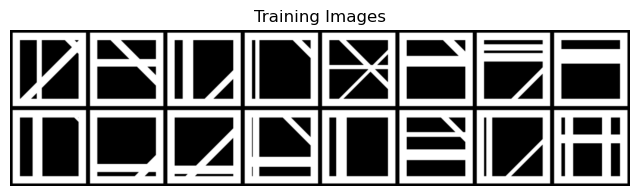

In [9]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [10]:
# Weight initialization before creation of Generator and Discriminator architecture

'''From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution\
with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional,\ 
convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models\
immediately after initialization.'''

# Custom weights initialization called on "Generator" and "Discriminator"

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    

In [11]:
# Creation of Generator model

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_vector, ngf*16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*16, ngf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
        )
        
    def forward(self, input):
        return self.main(input)

In [12]:
# Creating the Generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(200, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

In [13]:
# Creation of Discriminator model

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ndf*16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input)

In [14]:
# Creating the Discrminator

netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(2048, eps=1e-05, momen

In [20]:
# Implementing the BCELoss(Binary Cross Entropy Loss) as the primary loss function
'''The BCELoss gives the logarithmic values of the generated components from the Generator to the Discriminator.
    Defining 1 as the real label and 0 as the fake label. These labels will be used when calculating the losses of
    Discriminator and Generator.'''

#Initializing the BCELoss function
criterion = nn.BCELoss()

#Create the batch of the Latent Vectors that will be used to visualize the progression of the generator
'''These fixed latent vectors are used to consistently visualize the generator’s performance throughout training.
    By keeping the noise fixed, you can observe how the generated images evolve over time, 
    allowing for a clear comparison of improvements as training progresses.'''
fixed_noise = torch.randn(128, latent_vector, 1, 1, device=device) # Generates 128 noise vectors, each of dimension latent_vec, 1, 1

#Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

#Setup 'Adam' optimizer for D and G
optimizerD = optim.Adam(netD.parameters(), lr=0.00001, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [21]:
# Training Loop

# Setting up lists to track the progress
img_list = []
D_losses = []
G_losses = []
iters = 0

print("Starting the Training loop......")
# For each epochs
for epoch in range(num_of_epochs):
    # For each batch in the dataloasder
    for i, data in enumerate(dataloader, 0):
        ## (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Train with all real-batche
        netD.zero_grad()
        #Format batch
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        #Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        
        #Calculate loss on all real batch
        errD_real = criterion(output, label)
        
        #Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, latent_vector, 1, 1, device=device)
        
        #Generate fake-image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        #Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        
        #Calculate D's loss on all fake batch
        errD_fake = criterion(output, label)
        # Claculate gradients for this batch, accumulated with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        #Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_of_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_of_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        



Starting the Training loop......
[0/50][0/39]	Loss_D: 1.0100	Loss_G: 0.6931	D(x): 0.9999	D(G(z)): 0.0071 / 0.0000
[1/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[7/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[8/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[9/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[10/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[11/50][0/39]	Loss_D: 1.0064	Loss_G: 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 

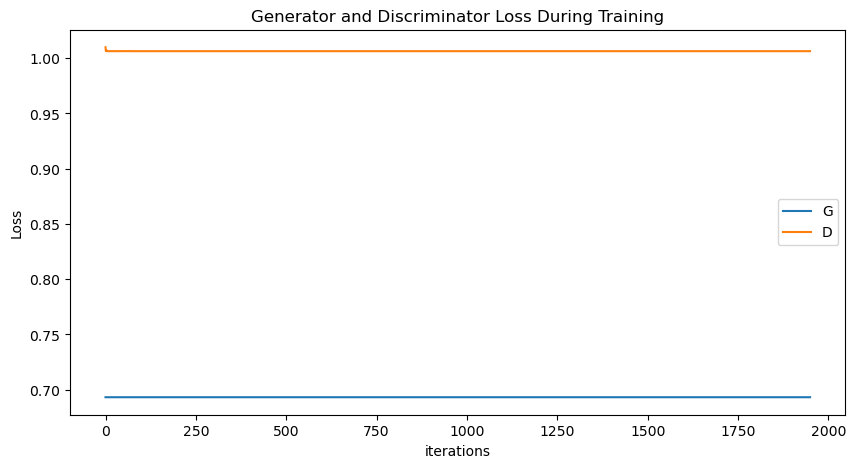

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
#plt.show()
plt.savefig("D:\Downloads\GAN.png")

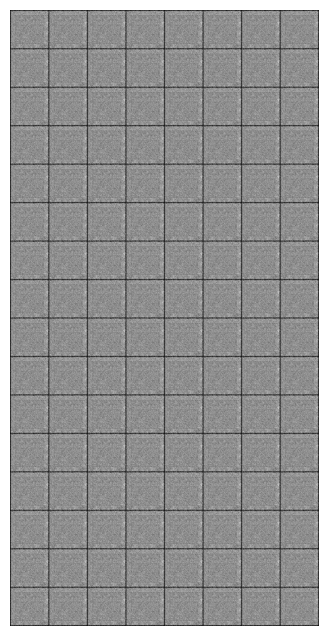

In [23]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
#ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

#HTML(ani.to_jshtml())